<a href="https://colab.research.google.com/github/pradeepvaranasi/ecommerce_clv/blob/main/ecommerce_clv_lifetimes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#### Problem Statement

The problem at hand involves predicting future purchasing behavior based on a historical dataset of customer transactions from an ecommerce store that specializes in selling widgets. The dataset comprises approximately 50,000 transactions, with each transaction record containing information such as CustomerID, Timestamp, and PurchaseValue. The goal is to leverage the modified beta geometric and gamma gamma models provided by the lifetimes Python library to create a predictive model for customer purchasing behavior.

In [ ]:
# installing lifetimes package
# !pip install Lifetimes

#### Importing libraries

In [61]:
# importing libraries
import pandas as pd
import numpy as np
import datetime as dt
from operator import attrgetter
from sklearn.cluster import KMeans
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes.utils import calculate_alive_path, expected_cumulative_transactions
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
from lifetimes.plotting import plot_period_transactions
from lifetimes.plotting import plot_frequency_recency_matrix, plot_probability_alive_matrix
from lifetimes.plotting import plot_history_alive
from sklearn.metrics import (silhouette_score,
                             calinski_harabasz_score,
                             davies_bouldin_score, mean_squared_error)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#### Data Exploration

In [3]:
# importing data
data = pd.read_csv('data.csv')

In [4]:
# copying the data to dataframe df
df = data.copy()

In [5]:
# checking the first n rows
df.head(2)

,CustomerID,Timestamp,PurchaseValue
0,5611860a94204a4078659f1667372cc4,2017-02-09T18:31:00Z,4.72
1,07b260307114f9cffc5601eb7ad4b565,2017-06-28T19:26:00Z,5.33


In [6]:
# checking the shape of the dataframe
df.shape

(49945, 3)

In [7]:
# checking for duplicates
df.duplicated().sum()

0

In [8]:
# Explore basic characteristics of the data
print("Basic Data Information:")
df.info()

Basic Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49945 entries, 0 to 49944
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CustomerID     49945 non-null  object 
 1   Timestamp      49945 non-null  object 
 2   PurchaseValue  49945 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.1+ MB


From the above, we could infer
1. There are no missing values in the data
2. There are no duplicate values in the data
3. The *Timestamp* feature should be coverted to datetime object

In [9]:
# reconfirming the missing values in the data
df.isnull().sum()

CustomerID       0
Timestamp        0
PurchaseValue    0
dtype: int64

#### Data Preprocessing

In [10]:
# Timestamp feature conversion to datatime object
df['Timestamp'] = pd.to_datetime(df['Timestamp']).dt.date
df.head(2)

,CustomerID,Timestamp,PurchaseValue
0,5611860a94204a4078659f1667372cc4,2017-02-09,4.72
1,07b260307114f9cffc5601eb7ad4b565,2017-06-28,5.33


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49945 entries, 0 to 49944
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CustomerID     49945 non-null  object 
 1   Timestamp      49945 non-null  object 
 2   PurchaseValue  49945 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.1+ MB


In [12]:
# descriptive stats for the PurchaseValue feature
df['PurchaseValue'].describe()

count    49945.000000
mean       236.888196
std        245.760987
min          4.720000
25%         97.100000
50%        166.660000
75%        286.790000
max      11599.680000
Name: PurchaseValue, dtype: float64

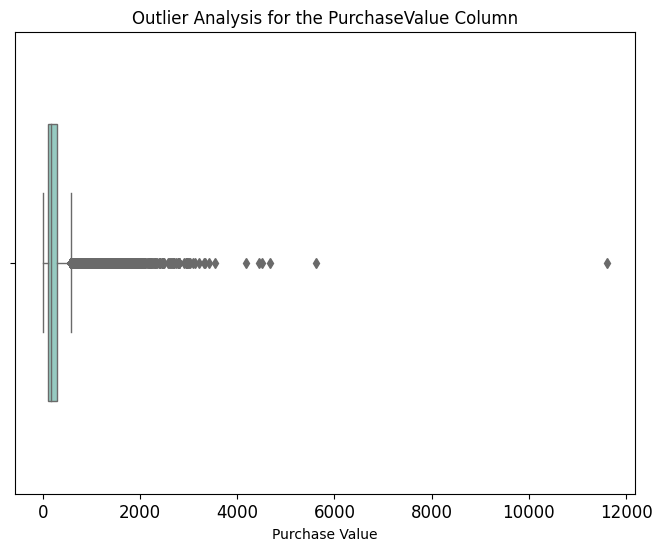

In [13]:
# Create a boxplot
plt.figure(figsize=(8, 6))  # Adjust the figure size

# Customize the color palette for better visibility
sns.set_palette("Set3")

# Increase the linewidth of the box and whiskers
sns.boxplot(x=df['PurchaseValue'], linewidth=1, width=0.6)

# Set labels and title
plt.xlabel('Purchase Value')
plt.title('Outlier Analysis for the PurchaseValue Column')

# Customize tick labels
plt.xticks(fontsize=12)

# Show the plot
plt.show()

In [14]:
# defining function to treat outliers

def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return up_limit, low_limit

def replace_with_threshold(dataframe, variable):
    up_limit, low_limit = outlier_thresholds(dataframe, variable)
    # dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [15]:
replace_with_threshold(df, "PurchaseValue")

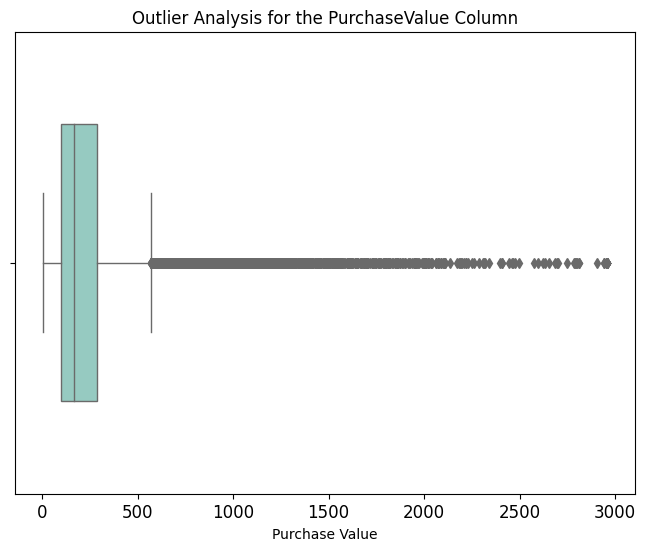

In [16]:
# Create a boxplot
plt.figure(figsize=(8, 6))  # Adjust the figure size

# Customize the color palette for better visibility
sns.set_palette("Set3")

# Increase the linewidth of the box and whiskers
sns.boxplot(x=df['PurchaseValue'], linewidth=1, width=0.6)

# Set labels and title
plt.xlabel('Purchase Value')
plt.title('Outlier Analysis for the PurchaseValue Column')

# Customize tick labels for better readability
plt.xticks(fontsize=12)

# Show the plot
plt.show()

In [17]:
df.head(2)

,CustomerID,Timestamp,PurchaseValue
0,5611860a94204a4078659f1667372cc4,2017-02-09,4.72
1,07b260307114f9cffc5601eb7ad4b565,2017-06-28,5.33


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49945 entries, 0 to 49944
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CustomerID     49945 non-null  object 
 1   Timestamp      49945 non-null  object 
 2   PurchaseValue  49945 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.1+ MB


#### Building RFMT dataframe

In [19]:
df['Timestamp'].max()

datetime.date(2017, 12, 6)

In [20]:
df['Timestamp'].min()

datetime.date(2016, 11, 30)

In [21]:
diff_time = df['Timestamp'].max() - df['Timestamp'].min()
diff_time

datetime.timedelta(days=371)

In [22]:
df_rfmt = summary_data_from_transaction_data(transactions = df,
                                         customer_id_col = 'CustomerID',
                                         datetime_col = 'Timestamp',
                                         monetary_value_col = 'PurchaseValue')

df_rfmt = df_rfmt.reset_index()
df_rfmt.head()

,CustomerID,frequency,recency,T,monetary_value
0,0001117ff1305c1fe840697166e61564,1.0,11.0,344.0,87.280
1,00028502859fd7e111d88c20456b59d5,0.0,0.0,342.0,0.000
2,000306d200fd6e9b03de48d15348f5c2,0.0,0.0,33.0,0.000
3,0003f3458a6e7b495a975c2d9ddda559,2.0,285.0,343.0,88.065
4,000784b838b807ad589d4bc69c0c562f,0.0,0.0,210.0,0.000


#### BG/NBD Assumptions and Model Building

In [23]:
# df_rfmt = df_rfmt[df_rfmt['frequency']>0]

**BG/NBD**
1. Each individual, i, has hidden λ (lambda) and p parameters.
  
> The assumption of hidden parameters is common in statistical models, allowing for variability across individuals. This is reasonable for modeling customer behavior, as different customers may have different purchasing patterns.


2. These parameters come from population-wide Gamma and Beta distributions, respectively.

> Assuming that individual parameters come from Gamma and Beta distributions implies heterogeneity in the population. This is suitable for capturing diverse customer behaviors, as some may be more loyal (higher λ) or more prone to dropout (higher p).

3. Individual purchases follow a Poisson process with rate λ_i * t.

> The assumption that purchases follow a Poisson process means that the timing between purchases is memoryless. In an e-commerce context, this may not always hold true, as some customers may exhibit seasonality or other temporal patterns.

4. After each purchase, an individual has a probability p_i of never buying again.

> The assumption that after each purchase, there's a probability of never buying again aligns with the concept of customer churn. However, in practice, customers may have more complex behavior, with potential for multiple purchases even after periods of inactivity.

In [24]:
# Getting the ending date of the calibration period.
end_date_cal = df['Timestamp'].min() + dt.timedelta(days=200)
end_date_obs = end_date_cal + (diff_time - dt.timedelta(days=200))

In [25]:
print(end_date_cal)
print(end_date_obs)

2017-06-18
2017-12-06


In [26]:
# spliting calibration and holdout period
df_rfmt_cal = calibration_and_holdout_data(transactions=df,
                                          customer_id_col="CustomerID",
                                          datetime_col = "Timestamp",
                                          calibration_period_end=end_date_cal,
                                          observation_period_end= end_date_obs)
df_rfmt_cal.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
CustomerID,,,,,
0001117ff1305c1fe840697166e61564,1.0,11.0,173.0,0.0,171.0
00028502859fd7e111d88c20456b59d5,0.0,0.0,171.0,0.0,171.0
0003f3458a6e7b495a975c2d9ddda559,1.0,2.0,172.0,1.0,171.0
000784b838b807ad589d4bc69c0c562f,0.0,0.0,39.0,0.0,171.0
000ad0f90e9fcb6ff5a0bc480cccbdb3,1.0,4.0,29.0,4.0,171.0


##### Choosing l2_coeff

In [27]:
import warnings
warnings.filterwarnings("ignore")
l2_coefs = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.1, 0.2, 0.3, 0.4, 0.5]
l2_list = []
rmse_list = []
for coef in l2_coefs :
    # Fitting the model using the calibration dataset.
    model = BetaGeoFitter(penalizer_coef=coef)
    model.fit(df_rfmt_cal['frequency_cal'],
        df_rfmt_cal['recency_cal'],
        df_rfmt_cal['T_cal'])
    # Predicting the frequency for the holdout period for all customers.
    pred_freq = pd.DataFrame(model.predict(df_rfmt_cal['duration_holdout'],
                                 df_rfmt_cal['frequency_cal'], df_rfmt_cal['recency_cal'], df_rfmt_cal['T_cal']), columns=['pred_frequency']).reset_index()
    # Merging the two dataframes and dropping NaN values.
    new_df = df_rfmt_cal.reset_index().merge(pred_freq, on='CustomerID').dropna()

    # Computing the rmse score
    rmse_score = np.sqrt(mean_squared_error(new_df['frequency_holdout'],new_df['pred_frequency']))
    l2_list.append(coef)
    rmse_list.append(rmse_score)

# Getting the results
resl = pd.DataFrame(np.array(rmse_list), columns=['rmse_score'])\
             .merge(pd.DataFrame(np.array(l2_list), columns=['L2 coefs']), right_index=True, left_index=True)
resl

,rmse_score,L2 coefs
0,1.492694,0.01
1,1.424845,0.02
2,1.418836,0.03
3,1.418747,0.04
4,1.423855,0.05
5,1.430207,0.06
6,1.459075,0.10
7,1.499654,0.20
8,1.527135,0.30
9,1.551350,0.40


In [28]:
# Fitting the model using the calibration dataset.
model = BetaGeoFitter(penalizer_coef=0.04)
model.fit(df_rfmt_cal['frequency_cal'],
        df_rfmt_cal['recency_cal'],
        df_rfmt_cal['T_cal'])

<lifetimes.BetaGeoFitter: fitted with 14638 subjects, a: 0.11, alpha: 39.14, b: 0.27, r: 0.33>

##### Calibration vs. holdout purchases

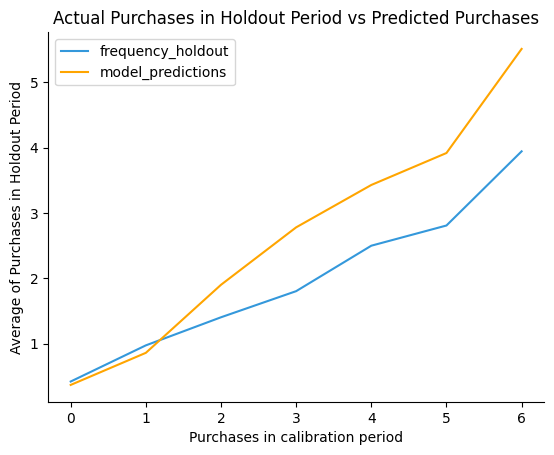

In [29]:
# Plotting the calibration vs. holdout purchases
import warnings
warnings.filterwarnings("ignore")

custom_palette = ['#3498db', '#85c1e9']  # Dark blue and light blue

# Plot the calibration vs. holdout purchases with custom colors
plot_calibration_purchases_vs_holdout_purchases(model, df_rfmt_cal, color=['#3498db','#FFA500'])
sns.despine();

In [30]:
# Predicting the number of purchases in the next 365 days for all customers.
df_rfmt['predicted_purchases'] = model.conditional_expected_number_of_purchases_up_to_time(365,
                                                                                      df_rfmt['frequency'],
                                                                                      df_rfmt['recency'],
                                                                                      df_rfmt['T'])
df_rfmt.dropna(inplace=True)
# Getting rid of negative values.
df_rfmt = df_rfmt[df_rfmt['monetary_value']>0]
df_rfmt.head()

,CustomerID,frequency,recency,T,monetary_value,predicted_purchases
0,0001117ff1305c1fe840697166e61564,1.0,11.0,344.0,87.280,0.160913
3,0003f3458a6e7b495a975c2d9ddda559,2.0,285.0,343.0,88.065,1.862973
5,0008e6b90a8f191089e8a0757fabf968,1.0,69.0,77.0,145.540,2.477416
6,00090b9fa28029c4839ca0a0306b6b11,1.0,61.0,82.0,349.440,2.259246
7,000ad0f90e9fcb6ff5a0bc480cccbdb3,5.0,68.0,200.0,229.782,2.601450



#### Gamma-Gamma Model Assumptions and Model Buildings


**Gamma-Gamma Model**
1. The monetary value of a customer’s given transaction varies randomly around their average transaction value.

> This assumption is reasonable for e-commerce, where customers may make transactions of different sizes. However, it assumes that the variation is captured well by a Gamma distribution.

2. Average transaction value varies across customers but do not vary over time for any given customer.

> This assumption implies that the average transaction value for a customer remains stable over time. In practice, this might not always hold true, especially if customers' purchasing behavior changes.

3. The distribution of average transaction values across customers is independent of the transaction process.

> This assumption suggests that the variability in average transaction values is unrelated to the frequency and recency of transactions. It may be reasonable if customers with different purchasing patterns can still have similar average transaction values.

In [31]:
df_rfmt[['frequency', 'monetary_value']].corr()

,frequency,monetary_value
frequency,1.000000,0.041614
monetary_value,0.041614,1.000000


In [32]:
# Fitting the GammaGamma model

gg_model = GammaGammaFitter()
gg_model.fit(df_rfmt['frequency'], df_rfmt['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 9647 subjects, p: 4.55, q: 3.66, v: 136.61>

In [33]:
df_rfmt['pred_monetary'] = gg_model.conditional_expected_average_profit(
        df_rfmt['frequency'],
        df_rfmt['monetary_value'])
df_rfmt.head()

,CustomerID,frequency,recency,T,monetary_value,predicted_purchases,pred_monetary
0,0001117ff1305c1fe840697166e61564,1.0,11.0,344.0,87.280,0.160913,141.402969
3,0003f3458a6e7b495a975c2d9ddda559,2.0,285.0,343.0,88.065,1.862973,121.059890
5,0008e6b90a8f191089e8a0757fabf968,1.0,69.0,77.0,145.540,2.477416,178.198740
6,00090b9fa28029c4839ca0a0306b6b11,1.0,61.0,82.0,349.440,2.259246,306.977625
7,000ad0f90e9fcb6ff5a0bc480cccbdb3,5.0,68.0,200.0,229.782,2.601450,230.242024


In [34]:
# Predicting the CLV.
df_rfmt['CLV'] = gg_model.customer_lifetime_value(
    model,
    df_rfmt['frequency'],
    df_rfmt['recency'],
    df_rfmt['T'],
    df_rfmt['monetary_value'],
    time = 12,# In months
    )
df_rfmt.head()

,CustomerID,frequency,recency,T,monetary_value,predicted_purchases,pred_monetary,CLV
0,0001117ff1305c1fe840697166e61564,1.0,11.0,344.0,87.280,0.160913,141.402969,21.086114
3,0003f3458a6e7b495a975c2d9ddda559,2.0,285.0,343.0,88.065,1.862973,121.059890,208.952056
5,0008e6b90a8f191089e8a0757fabf968,1.0,69.0,77.0,145.540,2.477416,178.198740,409.660111
6,00090b9fa28029c4839ca0a0306b6b11,1.0,61.0,82.0,349.440,2.259246,306.977625,643.533193
7,000ad0f90e9fcb6ff5a0bc480cccbdb3,5.0,68.0,200.0,229.782,2.601450,230.242024,555.072573


In [98]:
# no negative CLV values
df_rfmt[df_rfmt['CLV'] < 0].shape

(0, 8)

#### Top 100 customers

In [35]:
# top 100 customers predicted to make the most purchases
top_customers_purchases = df_rfmt.sort_values(by='predicted_purchases', ascending=False).head(100)['CustomerID'].tolist()


In [36]:
# the top 100 customers predicted to spend the most
top_customers_spending = df_rfmt.sort_values(by='pred_monetary', ascending=False).head(100)['CustomerID'].tolist()


In [37]:
df_rfmt.shape

(9647, 8)

In [99]:
df_rfmt.head()

,CustomerID,frequency,recency,T,monetary_value,predicted_purchases,pred_monetary,CLV
0,0001117ff1305c1fe840697166e61564,1.0,11.0,344.0,87.280,0.160913,141.402969,21.086114
3,0003f3458a6e7b495a975c2d9ddda559,2.0,285.0,343.0,88.065,1.862973,121.059890,208.952056
5,0008e6b90a8f191089e8a0757fabf968,1.0,69.0,77.0,145.540,2.477416,178.198740,409.660111
6,00090b9fa28029c4839ca0a0306b6b11,1.0,61.0,82.0,349.440,2.259246,306.977625,643.533193
7,000ad0f90e9fcb6ff5a0bc480cccbdb3,5.0,68.0,200.0,229.782,2.601450,230.242024,555.072573


In [38]:
df_rfmt = df_rfmt[df_rfmt['frequency'] > 0]
df_rfmt.shape

(9647, 8)

#### Evaluation

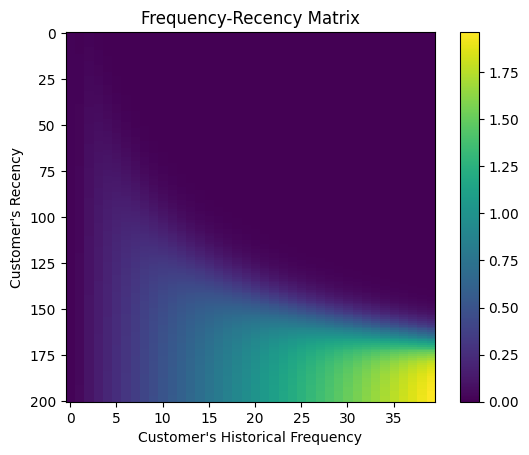

In [39]:
# Plot Frequency-Recency Matrix
plot_frequency_recency_matrix(model, T=12)
plt.title('Frequency-Recency Matrix')
plt.show()

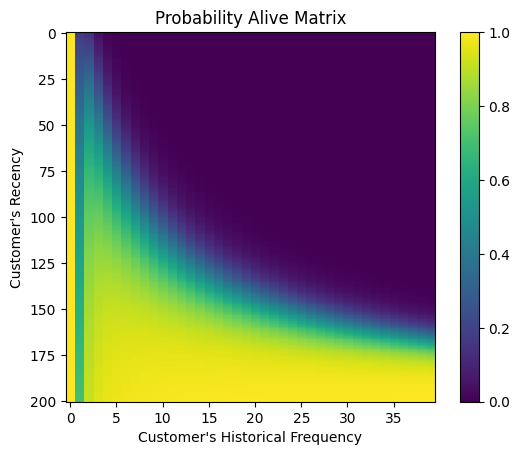

In [59]:
# Plot Probability Alive Matrix
plot_probability_alive_matrix(model)
plt.title('Probability Alive Matrix')
plt.show()

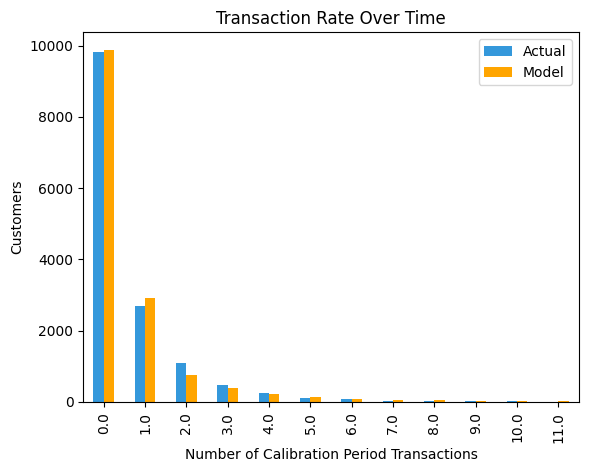

In [41]:
# Plot Transaction Rate over Time
plot_period_transactions(model, max_frequency=12, color=['#3498db','#FFA500'])
plt.title('Transaction Rate Over Time')
plt.show()

Simulations

In [100]:
# generating a random sample of 100 customers
# setting seed for reproducibility
df_rfmt_sample = df_rfmt.sample(n=100, replace=False, random_state=42)

In [120]:
df_rfmt_sample.sort_values(by=['predicted_purchases'], ascending=False).head()

,CustomerID,frequency,recency,T,monetary_value,predicted_purchases,pred_monetary,CLV
17519,bcf1f968bf4bf2b9241f77366a4aee86,14.0,360.0,367.0,143.992143,12.215578,147.599865,1669.925617
10166,6de36cee17e524ae6d7e03fe59a8335c,6.0,79.0,117.0,446.786667,12.026902,427.948528,4771.679515
6971,4b669fc1c9dbc9a55e3faa7ad1b7ddc5,11.0,270.0,283.0,287.254545,11.989196,284.581979,3160.728466
8789,5e8c44c69fbd335920ab612aeac172c5,5.0,124.0,131.0,330.790000,10.162459,320.696936,3021.297557
10553,71ed4f4a5723cac8afb29810e6c94433,6.0,162.0,177.0,305.773333,9.628125,299.430062,2671.890960


#### Simulation - 10 days, 1 year, 10 years, 100 years

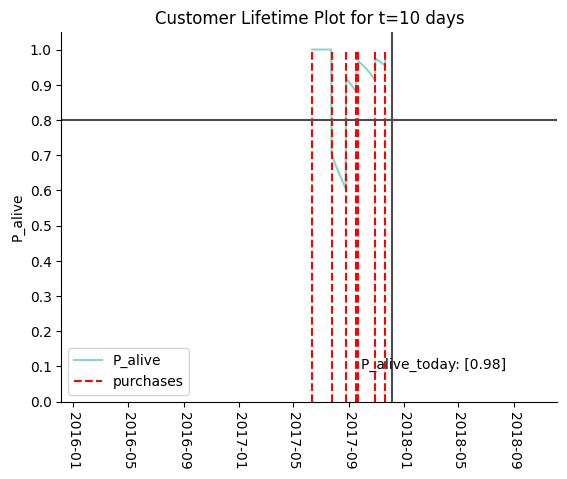

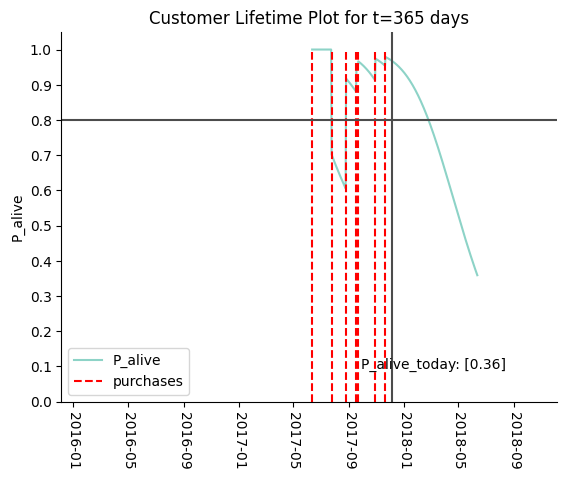

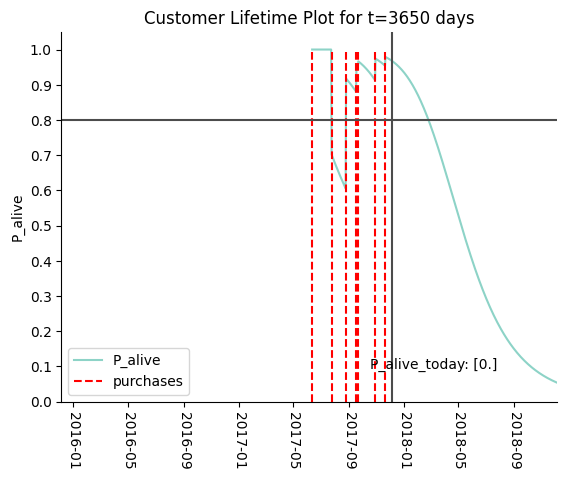

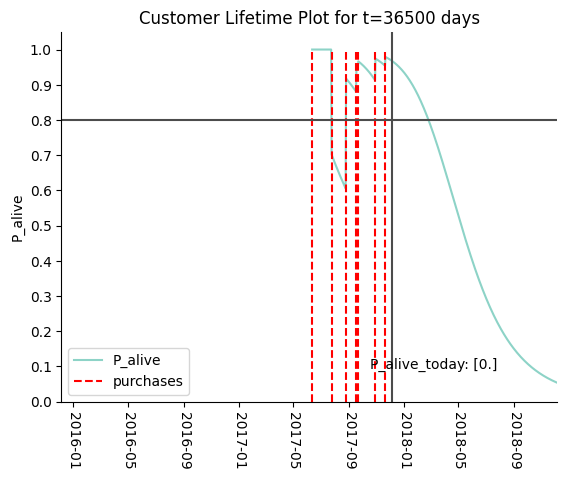

In [132]:
from lifetimes.plotting import plot_history_alive
from datetime import date
from pylab import figure, text, scatter, show
import pandas as pd
import numpy as np
import seaborn as sns


today = df['Timestamp'].max()
two_year_ago = today.replace(year=today.year - 2)
one_year_from_now = today.replace(year=today.year + 1)

sp_trans = df.loc[df['CustomerID'] == '71ed4f4a5723cac8afb29810e6c94433']
sp_trans['Timestamp'] = pd.to_datetime(sp_trans['Timestamp'])

# List of different t values
t_values = [10, 365, 3650, 36500]  # 10 days, 1 year, 10 years, 100 years

for t in t_values:
    t_days_ago = (today - pd.DateOffset(days=t)).date()

    p_alive_today = pd.DataFrame(calculate_alive_path(model, sp_trans, 'Timestamp', t, freq='D'))[0].tail(1).values
    p_alive_today = np.round(p_alive_today[0], 2)

    ax = plot_history_alive(model, t, sp_trans, 'Timestamp', start_date=two_year_ago)
    ax.vlines(x=today, ymin=0, ymax=1.05, colors='#4C4C4C')
    ax.hlines(y=0.8, xmin=two_year_ago, xmax=one_year_from_now, colors='#4C4C4C')

    ax.set_xlim(two_year_ago, one_year_from_now)
    ax.set_ylim(0, 1.05)

    plt.xticks(rotation=-90)
    text(0.75, 0.1, f'P_alive_today: {p_alive_today}', ha='center', va='center', transform=ax.transAxes)

    sns.despine()
    plt.title(f'Customer Lifetime Plot for t={t} days')
    plt.show()
    print("                                                      ")


Approach-2 (unused)


In [44]:
# # Create rfm data for Lifetimes
# max_date = df['Timestamp'].max()

# rfm = df.groupby('CustomerID').agg({'Timestamp': lambda x: (max_date - x.max()).days,
#                                     'CustomerID': lambda x: x.count(),
#                                     'PurchaseValue': lambda x: x.sum()})

# rfm.columns = ['recency', 'frequency', 'monetary']
# rfm = rfm.reset_index()
# rfm.head()

Building CLTV

In [45]:
# # calculate the cltv for the base data

# cltv_df = df.groupby("CustomerID").agg(
#     {
#         "Timestamp": [
#             lambda x: (x.max() - x.min()).days,
#             lambda x: (max_date - x.min()).days,
#         ],
#         "CustomerID": "count",
#         "PurchaseValue": "sum",
#     }
# )

# cltv_df.columns = cltv_df.columns.droplevel(0)
# cltv_df.columns = ["recency", "T", "frequency", "monetary"]
# cltv_df = cltv_df.reset_index()
# cltv_df.head()

In [46]:
# #Average Order Value
# cltv_df["monetary"] = cltv_df["monetary"] / cltv_df["frequency"]

# #Recency & Tenure
# cltv_df["recency"] = cltv_df["recency"] / 7
# cltv_df["T"] = cltv_df["T"] / 7

# #Frequency
# cltv_df = cltv_df[(cltv_df['frequency'] > 1)]

In [47]:
# cltv_df.shape

Model Building

In [48]:
# BGF = BetaGeoFitter(penalizer_coef=0.001)  # avoid overfitting

# BGF.fit(cltv_df["frequency"], cltv_df["recency"], cltv_df["T"])

1 week test

In [49]:
# BGF.conditional_expected_number_of_purchases_up_to_time(
#     1, cltv_df["frequency"], cltv_df["recency"], cltv_df["T"]
# ).sort_values(ascending=False).head(10).to_frame(
#     "Expected Number of Transactions"
# ).reset_index()

 Evaluation

In [50]:
# import seaborn as sns
# from lifetimes.plotting import plot_period_transactions
# from matplotlib.ticker import ScalarFormatter

# # plotting BetaGeoFitter model
# ax = plot_period_transactions(BGF, max_frequency=7, figsize=(10, 6),  color=['#3498db', '#85c1e9', '#ccd1d1'])
# ax.set_yscale('log')

# # # defining y-axis ticks and labels
# # ax.set_yticks([1, 2, 5, 10, 20, 50, 100, 200])
# # ax.get_yaxis().set_major_formatter(ScalarFormatter())

# # setting labels and title
# ax.set_xlabel('Number of Repeat Transactions')
# ax.set_ylabel('Number of Customers (log scale)')
# ax.set_title('Actual vs. Predicted Repeat Transactions')

# sns.despine();